In [1]:
%matplotlib widget

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from lux_entry.training.env import make_env

In [2]:
env = make_env(0)()
full_obs_dict = env.reset()

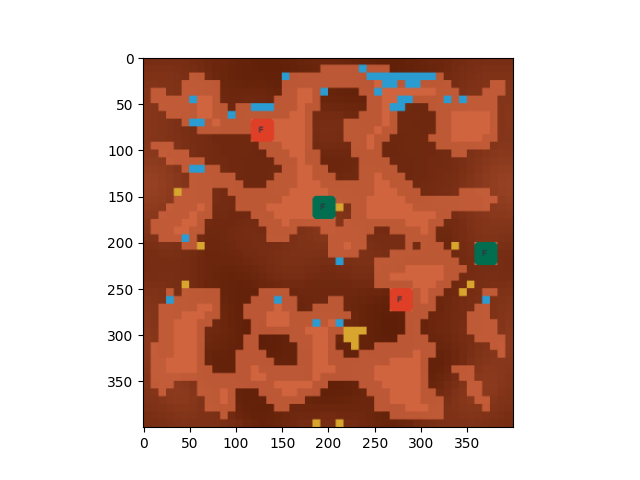

In [7]:
img = env.render("rgb_array")
plt.figure()
plt.imshow(img)

In [4]:
def show_plot(obs_dict: dict, key: str, i: int):
    plt.figure()
    data = obs_dict[key][i]
    data = np.transpose(data)
    title = f"{key} - {i}"
    plt.imshow(data, vmin=-1, vmax=1, cmap='gray')
    plt.title(title)
    plt.show()
    
def display_key(obs_dict, key: str):
    plt.close()
    if type(obs_dict[key]) in [dict, int]:
        return
    for i in range(obs_dict[key].shape[0]):
        show_plot(obs_dict, key, i)
     
keys = list(full_obs_dict.keys())
widgets.interact(lambda key: display_key(full_obs_dict, key), key=keys);

interactive(children=(Dropdown(description='key', options=('has_ice', 'has_ore', 'player_has_factory', 'player…

In [14]:
from torch import Tensor

from lux_entry.training.model import MapFeaturesExtractor, JobNet, JobActionNet, ActorCriticNet, CustomActorCriticPolicy, get_model
from lux_entry.training.observations import get_full_obs_space

In [65]:
full_obs_space = get_full_obs_space(env.state.env_cfg)
map_features_extractor = MapFeaturesExtractor(full_obs_space)
actor_critic_net = ActorCriticNet()

In [66]:
batch_full_obs_dict = {
    k: v.unsqueeze(0)
    for k, v in full_obs_dict.items()
}
batch_map_features = map_features_extractor(batch_full_obs_dict)

In [67]:
keys = list(full_obs_dict.keys())
keys.remove("player_has_factory")
keys.remove("player_has_robot")
keys = ["my_factories", "my_robots", "opp_factories", "opp_robots"] + keys
keys = [
    k
    for key in keys
    for k in (
        [key + "[0]", key + "[1]"]
        if key.startswith("player")
        else [key]
    )
]
keys = keys + [
    f"Convoluted pixel layer {i}"
    for i in range(32)
] + [
    f"Whole map feature layer {i}"
    for i in range(128 - len(keys) - 32)
]

def plot_layer(map_features: Tensor, key: str):
    plt.figure()
    i = keys.index(key)
    data = map_features[i]
    data = np.transpose(data)
    title = f"Layer {i} - {keys[i]}"
    plt.imshow(data, vmin=-1, vmax=1, cmap='gray')
    plt.title(title)
    plt.show()

widgets.interact(lambda key: plot_layer(batch_map_features[0], key), key=keys);

interactive(children=(Dropdown(description='key', options=('my_factories', 'my_robots', 'opp_factories', 'opp_…

In [72]:
batch_action_logits, batch_value = actor_critic_net(batch_map_features)
batch_value

tensor([[-0.0803]], grad_fn=<AddmmBackward0>)

In [78]:
def plot_logits(action_logits: Tensor, action: int):
    plt.figure()
    data = action_logits[action]
    data = np.transpose(data)
    title = f"Action {action}"
    plt.imshow(data, vmin=-1, vmax=1, cmap='gray')
    plt.title(title)
    plt.show()

detached_action_logits = batch_action_logits.detach().numpy()
widgets.interact(lambda action: plot_logits(detached_action_logits[0], action), action=range(batch_action_logits.shape[1]));

interactive(children=(Dropdown(description='action', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0),…

In [83]:
detached_action_logits[0,:,15,9]

array([-262017.97 ,  115664.5  , -165477.95 ,   78005.836,  135584.23 ,
         19947.06 , -114168.68 ,  202553.45 , -263590.22 , -179735.48 ,
       -237871.73 ,  105590.94 ], dtype=float32)